In [1]:
import torch
import torchviz
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear,ReLU,Sigmoid,Tanh
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
import joblib
from torch.utils.tensorboard import SummaryWriter
import warnings;warnings.simplefilter('ignore')
from tqdm import tqdm_notebook as tqdm
import os
from sklearn.utils import shuffle
import random
random.seed(42)
torch.manual_seed(42)
root = '../data/phase_2/cleaned/'
os.listdir(root)

['col_names.pkl', 'train.csv', 'train(energy).csv']

In [2]:
col_names = joblib.load(root+'col_names.pkl')
col_names.keys()

dict_keys(['xna', 'xle', 'xhc', 'xhe', 'fna', 'fle', 'fhc', 'fhe', 'yld', 'Tray_temp', 'duty', 'Rate_m3', 'Rate_ton', 'sle', 'shc', 'she', 'case'])

In [3]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_col(df,name):
    condition = df.columns.str.contains(name)
    return df.columns[condition].tolist()

# load data

In [4]:
df = pd.read_csv(root+'train.csv',index_col=0).dropna(axis=0)
print(df.shape)
df.head()

(16498, 403)


,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,Naphtha Properties_n-Pentane_wt%,Naphtha Properties_tr2-Pentene_wt%,Naphtha Properties_Cyclopentane_wt%,Naphtha Properties_3-Methylpentane_wt%,...,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene_Ratio",Individual Component to Heavy End Split Factor_n-Undecane_Ratio,Individual Component to Heavy End Split Factor_n-Pentylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Dodecane_Ratio,Individual Component to Heavy End Split Factor_n-Hexylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Tridecane_Ratio,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%
001-01,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.409138,0.433925,0.440811,0.451332,0.454764,1.0,10.0,2.5,100.0,1.0
001-02,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.397878,0.422758,0.429677,0.440263,0.443717,1.0,10.0,5.0,100.0,1.0
001-03,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.385311,0.410579,0.417606,0.428374,0.431884,1.0,10.0,10.0,100.0,1.0
001-04,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.387033,0.409416,0.415640,0.425230,0.428354,1.0,10.0,2.5,100.0,1.5
001-05,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.376672,0.399048,0.405285,0.414893,0.418027,1.0,10.0,5.0,100.0,1.5


# X,y

In [5]:
x_col = col_names['case']+col_names['xna']

In [6]:
y_col = col_names['duty'][1:]+col_names['Tray_temp']+col_names['fna']+col_names['yld']

In [7]:
y_col.remove('Yield Summary_Heart Cut Prod. Rate_m3/hr')#not need
y_col

['Duty_Condenser Heat Duty_Mkcal/hr',
 'Duty_Reboiler Heat Duty_Mkcal/hr',
 'Column Temp Profile_C011 Tray 15 Temp_oC',
 'Column Temp Profile_C013 Tray 16 Temp_oC',
 'Naphtha Properties_Naphtha Feed Rate_ton/hr',
 'Yield Summary_Reflux Rate_m3/hr',
 'Yield Summary_Light End Prod. Rate_m3/hr',
 'Yield Summary_Heavy End Prod. Rate_m3/hr']

In [8]:
df = shuffle(df)
X = df[x_col]
Y = df[y_col]

# scale X,y

In [9]:
mm_x = MinMaxScaler()
X[:] = mm_x.fit_transform(X[:])

In [10]:
mm_y = MinMaxScaler()
Y[:] = mm_y.fit_transform(Y[:])

# split train valid test

In [11]:
sp1 = int(len(X)*0.8)
sp2 = int(len(X)*0.9)

X_train,Y_train = X.iloc[:sp1,:],Y.iloc[:sp1,:]
X_valid,Y_valid = X.iloc[sp1:sp2,:],Y.iloc[sp1:sp2,:]
X_test,Y_test = X.iloc[sp2:,:],Y.iloc[sp2:,:]

print(X_train.shape,X_valid.shape,X_test.shape)
print(Y_train.shape,Y_valid.shape,Y_test.shape)

(13198, 58) (1650, 58) (1650, 58)
(13198, 8) (1650, 8) (1650, 8)


# to torch tensor

In [12]:
X_train = torch.tensor(X_train.values,dtype=torch.float)#.cuda()
X_valid = torch.tensor(X_valid.values,dtype=torch.float)#.cuda()
X_test = torch.tensor(X_test.values,dtype=torch.float)#.cuda()

Y_train = torch.tensor(Y_train.values,dtype=torch.float)#.cuda()
Y_valid = torch.tensor(Y_valid.values,dtype=torch.float)#.cuda()
Y_test = torch.tensor(Y_test.values,dtype=torch.float)#.cuda()

# data iter

In [13]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

In [14]:
datasets = torch.utils.data.TensorDataset(X_valid, Y_valid)
valid_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

# Construct the neural network

In [15]:
class model_tray(nn.Module):
    def __init__(self,input_shape,output_shape):
        super().__init__()
        self.fc1 = Linear(input_shape,128)
        self.fc2 = Linear(128,128)
        self.fc3 = Linear(128,output_shape)
    
    def forward(self,x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [16]:
def init_weights(m):
    if hasattr(m,'weight'):
        torch.nn.init.xavier_uniform(m.weight)
    if hasattr(m,'bias'):
        m.bias.data.fill_(0)

In [17]:
net = model_tray(len(x_col),len(y_col))#.cuda()
net.apply(init_weights)

model_tray(
  (fc1): Linear(in_features=58, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=8, bias=True)
)

In [18]:
net(X_test)

tensor([[0.5350, 0.4227, 0.4783,  ..., 0.6517, 0.4950, 0.5042],
        [0.5934, 0.4311, 0.4901,  ..., 0.6235, 0.5504, 0.4591],
        [0.5109, 0.4385, 0.4597,  ..., 0.5861, 0.4495, 0.5502],
        ...,
        [0.5174, 0.4397, 0.4296,  ..., 0.5732, 0.4238, 0.5520],
        [0.5630, 0.4579, 0.4295,  ..., 0.6421, 0.4476, 0.4759],
        [0.5238, 0.4815, 0.4159,  ..., 0.6202, 0.4384, 0.5415]],
       grad_fn=<SigmoidBackward>)

# loss_function and optimizer

In [19]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

# train_loop

In [20]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            # weight update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # record loss
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            # record loss
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
            epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = net
            print('record net')
    
    # when end all epoch plot history
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    # return best_net
    return best_net

epochs 0 train loss 0.0109 valid loss 0.0044
record net
epochs 1 train loss 0.0036 valid loss 0.0027
record net
epochs 2 train loss 0.0024 valid loss 0.0021
record net
epochs 3 train loss 0.0021 valid loss 0.0019
record net
epochs 4 train loss 0.0020 valid loss 0.0018
record net
epochs 5 train loss 0.0019 valid loss 0.0018
epochs 6 train loss 0.0019 valid loss 0.0018
record net
epochs 7 train loss 0.0018 valid loss 0.0017
record net
epochs 8 train loss 0.0018 valid loss 0.0016
record net
epochs 9 train loss 0.0018 valid loss 0.0016
record net
epochs 10 train loss 0.0017 valid loss 0.0017
epochs 11 train loss 0.0017 valid loss 0.0016
record net
epochs 12 train loss 0.0016 valid loss 0.0016
epochs 13 train loss 0.0015 valid loss 0.0014
record net
epochs 14 train loss 0.0014 valid loss 0.0013
record net
epochs 15 train loss 0.0013 valid loss 0.0013
record net
epochs 16 train loss 0.0012 valid loss 0.0011
record net
epochs 17 train loss 0.0011 valid loss 0.0011
record net
epochs 18 train l

epochs 166 train loss 0.0003 valid loss 0.0002
epochs 167 train loss 0.0002 valid loss 0.0002
epochs 168 train loss 0.0003 valid loss 0.0003
epochs 169 train loss 0.0003 valid loss 0.0002
epochs 170 train loss 0.0002 valid loss 0.0003
epochs 171 train loss 0.0003 valid loss 0.0002
epochs 172 train loss 0.0003 valid loss 0.0004
epochs 173 train loss 0.0003 valid loss 0.0002
epochs 174 train loss 0.0002 valid loss 0.0003
epochs 175 train loss 0.0003 valid loss 0.0002
epochs 176 train loss 0.0003 valid loss 0.0002
record net
epochs 177 train loss 0.0003 valid loss 0.0002
epochs 178 train loss 0.0002 valid loss 0.0002
record net
epochs 179 train loss 0.0003 valid loss 0.0005
epochs 180 train loss 0.0003 valid loss 0.0003
epochs 181 train loss 0.0003 valid loss 0.0002
epochs 182 train loss 0.0002 valid loss 0.0002
epochs 183 train loss 0.0003 valid loss 0.0002
epochs 184 train loss 0.0002 valid loss 0.0002
epochs 185 train loss 0.0003 valid loss 0.0003
epochs 186 train loss 0.0003 valid los

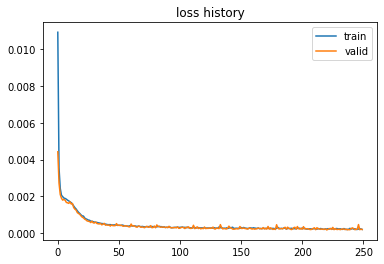

In [21]:
net = train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=250)

# make prediction

In [22]:
y_pred = net(X_test).detach().cpu().numpy()
y_pred = mm_y.inverse_transform(y_pred)
y_pred = pd.DataFrame(y_pred,columns=y_col)
y_pred.head()

,Duty_Condenser Heat Duty_Mkcal/hr,Duty_Reboiler Heat Duty_Mkcal/hr,Column Temp Profile_C011 Tray 15 Temp_oC,Column Temp Profile_C013 Tray 16 Temp_oC,Naphtha Properties_Naphtha Feed Rate_ton/hr,Yield Summary_Reflux Rate_m3/hr,Yield Summary_Light End Prod. Rate_m3/hr,Yield Summary_Heavy End Prod. Rate_m3/hr
0,2.761191,3.153227,104.510284,161.729630,86.765564,31.930733,6.560746,8.537059
1,5.051173,5.446420,107.550362,152.911545,84.450172,70.154831,1.445996,9.988047
2,4.804146,5.068373,97.293144,156.345947,92.305672,55.203438,12.797142,9.439410
3,5.311922,5.781369,96.230972,161.919464,86.932167,65.605774,9.045180,9.596161
4,3.081197,3.243652,96.749275,155.881866,88.516350,36.505894,8.233799,11.426437


In [23]:
y_real = Y_test.detach().cpu().numpy()
y_real = mm_y.inverse_transform(y_real)
y_real = pd.DataFrame(y_real,columns=y_col)
y_real.head()

,Duty_Condenser Heat Duty_Mkcal/hr,Duty_Reboiler Heat Duty_Mkcal/hr,Column Temp Profile_C011 Tray 15 Temp_oC,Column Temp Profile_C013 Tray 16 Temp_oC,Naphtha Properties_Naphtha Feed Rate_ton/hr,Yield Summary_Reflux Rate_m3/hr,Yield Summary_Light End Prod. Rate_m3/hr,Yield Summary_Heavy End Prod. Rate_m3/hr
0,2.757717,3.118826,104.358368,162.477905,86.429008,32.166061,6.528739,8.471404
1,3.660317,4.160728,106.641174,149.850128,83.728943,51.722427,0.943963,9.556031
2,4.776099,5.023252,97.198425,156.293823,92.090172,55.639202,12.827082,9.172112
3,5.230957,5.637347,96.034119,161.596802,87.104691,64.847435,8.890220,9.709836
4,3.037883,3.155574,96.714569,155.958496,88.737457,36.236652,8.198271,11.501717


# metric

In [24]:
res = pd.DataFrame(index=y_col,columns=['R2','MSE','MAPE'])

for i in y_col:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
Duty_Condenser Heat Duty_Mkcal/hr,0.952298,0.0650128,2.42023
Duty_Reboiler Heat Duty_Mkcal/hr,0.939305,0.0743208,2.36362
Column Temp Profile_C011 Tray 15 Temp_oC,0.994651,0.0683538,0.158969
Column Temp Profile_C013 Tray 16 Temp_oC,0.959249,1.72205,0.355111
Naphtha Properties_Naphtha Feed Rate_ton/hr,0.985803,0.479963,0.262633
Yield Summary_Reflux Rate_m3/hr,0.938586,12.2538,3.00616
Yield Summary_Light End Prod. Rate_m3/hr,0.998575,0.0493636,4.95445
Yield Summary_Heavy End Prod. Rate_m3/hr,0.703366,0.655476,2.20756
AVG,0.933979,1.92104,1.96609


# wrap model

In [25]:
class model_tray_wrapper(object):
    def __init__(self,x_col,y_col,mm_x,mm_y,net):
        self.x_col = x_col
        self.y_col = y_col
        self.mm_x = mm_x
        self.mm_y = mm_y
        self.net = net
    
    def predict(self,x):
        x = self.mm_x.transform(x)
        x = torch.tensor(x,dtype=torch.float)#.cuda()
        y = self.net(x).detach().cpu().numpy()
        y = self.mm_y.inverse_transform(y)
        y = pd.DataFrame(y,columns=self.y_col)
        assert np.all(y.values >= 0)
        return y

In [26]:
model = model_tray_wrapper(x_col,y_col,mm_x,mm_y,net.eval())

# test ANN_wrapper

In [27]:
X_test = mm_x.inverse_transform(X_test.detach().cpu().numpy())
X_test = pd.DataFrame(X_test,columns=x_col)
X_test.head()

,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane_wt%",Naphtha Properties_3-Methylnonane_wt%,Naphtha Properties_tert-Butylcyclohexane_wt%,Naphtha Properties_n-Decane_wt%,"Naphtha Properties_1,2-Diethylbenzene_wt%",Naphtha Properties_n-Undecane_wt%,Naphtha Properties_n-Pentylbenzene_wt%,Naphtha Properties_n-Dodecane_wt%,Naphtha Properties_n-Hexylbenzene_wt%,Naphtha Properties_n-Tridecane_wt%
0,10.0,10.0,100.0,1.00,0.0,0.0,0.0,0.022999,0.046999,0.388988,...,1.061968,2.477925,0.533984,0.714978,1.164965,0.134996,0.067998,0.002,0.013,0.0
1,30.0,10.0,100.0,0.05,0.0,0.0,0.0,0.004000,0.009000,0.073001,...,0.502010,1.173023,0.327007,0.298006,0.607012,0.056001,0.035001,0.001,0.007,0.0
2,30.0,2.5,100.0,1.00,0.0,0.0,0.0,0.040000,0.080999,0.669993,...,0.837992,1.954981,0.560994,1.503985,0.715993,0.283997,0.042000,0.005,0.008,0.0
3,30.0,2.5,100.0,1.00,0.0,0.0,0.0,0.002000,0.003000,0.025000,...,1.349000,3.148000,0.385000,0.846000,0.315000,0.160000,0.018000,0.003,0.004,0.0
4,10.0,2.5,100.0,2.00,0.0,0.0,0.0,0.040001,0.080002,0.665013,...,1.027020,2.398048,0.329007,0.639013,0.461009,0.121002,0.027001,0.002,0.005,0.0


In [28]:
Y_test = mm_y.inverse_transform(Y_test.detach().cpu().numpy())
Y_test = pd.DataFrame(Y_test,columns=y_col)
Y_test.head()

,Duty_Condenser Heat Duty_Mkcal/hr,Duty_Reboiler Heat Duty_Mkcal/hr,Column Temp Profile_C011 Tray 15 Temp_oC,Column Temp Profile_C013 Tray 16 Temp_oC,Naphtha Properties_Naphtha Feed Rate_ton/hr,Yield Summary_Reflux Rate_m3/hr,Yield Summary_Light End Prod. Rate_m3/hr,Yield Summary_Heavy End Prod. Rate_m3/hr
0,2.757717,3.118826,104.358368,162.477905,86.429008,32.166061,6.528739,8.471404
1,3.660317,4.160728,106.641174,149.850128,83.728943,51.722427,0.943963,9.556031
2,4.776099,5.023252,97.198425,156.293823,92.090172,55.639202,12.827082,9.172112
3,5.230957,5.637347,96.034119,161.596802,87.104691,64.847435,8.890220,9.709836
4,3.037883,3.155574,96.714569,155.958496,88.737457,36.236652,8.198271,11.501717


In [29]:
Y_pred = model.predict(X_test)
Y_pred

,Duty_Condenser Heat Duty_Mkcal/hr,Duty_Reboiler Heat Duty_Mkcal/hr,Column Temp Profile_C011 Tray 15 Temp_oC,Column Temp Profile_C013 Tray 16 Temp_oC,Naphtha Properties_Naphtha Feed Rate_ton/hr,Yield Summary_Reflux Rate_m3/hr,Yield Summary_Light End Prod. Rate_m3/hr,Yield Summary_Heavy End Prod. Rate_m3/hr
0,2.761191,3.153227,104.510284,161.729630,86.765564,31.930733,6.560745,8.537059
1,5.051173,5.446420,107.550362,152.911545,84.450172,70.154831,1.445996,9.988047
2,4.804146,5.068373,97.293144,156.345932,92.305672,55.203438,12.797144,9.439410
3,5.311922,5.781368,96.230972,161.919464,86.932167,65.605766,9.045178,9.596161
4,3.081196,3.243653,96.749275,155.881866,88.516350,36.505894,8.233797,11.426437
...,...,...,...,...,...,...,...,...
1645,2.726802,3.349592,97.329460,162.730835,92.122780,31.776520,5.850313,8.228397
1646,3.348989,3.671538,104.965851,161.981262,85.693886,39.069519,7.632376,9.032254
1647,3.908112,3.868304,96.739914,158.807098,94.769325,41.598534,15.469299,11.554347
1648,4.040797,3.600605,103.486282,143.457520,94.098053,42.274467,16.764242,9.428961


# metric

In [30]:
y_real = Y_test
y_pred = Y_pred

In [31]:
res = pd.DataFrame(index=y_col,columns=['R2','MSE','MAPE'])

for i in y_col:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
Duty_Condenser Heat Duty_Mkcal/hr,0.952298,0.0650128,2.42023
Duty_Reboiler Heat Duty_Mkcal/hr,0.939305,0.0743208,2.36362
Column Temp Profile_C011 Tray 15 Temp_oC,0.994651,0.0683538,0.158969
Column Temp Profile_C013 Tray 16 Temp_oC,0.959249,1.72205,0.355111
Naphtha Properties_Naphtha Feed Rate_ton/hr,0.985803,0.479963,0.262633
Yield Summary_Reflux Rate_m3/hr,0.938586,12.2538,3.00616
Yield Summary_Light End Prod. Rate_m3/hr,0.998575,0.0493636,4.95445
Yield Summary_Heavy End Prod. Rate_m3/hr,0.703366,0.655476,2.20756
AVG,0.933979,1.92104,1.96609


# save model

In [32]:
joblib.dump(model,'../model/ANN(tray).pkl')
print('save done!')

save done!
